# Hello, FABRIC: Create your first FABRIC slice

## Configure the Environment

### Import FABRIC API


In [54]:
import os
from fabrictestbed.slice_manager import SliceManager, Status, SliceState
import json

### Bastion Host and Keys

In order to minimize security incidents on FABRIC, access to VMs and other resources administered by users is controlled by a bastion host.  You will need to set up an ssh keypair that will be used to jump through the bastion host to your VMs and other resources. This keypair is unique to you and is only used to set up ssh proxy connections through the bastion host to your FABRIC resources. These proxies only setup secure paths through the bastion hosts. The paths are completed using additional ssh keys that are specified in the slice request and installed in the VMs. 

If you have not yet configured your bastion host ssh keypair, please follow the instructions [here](./bastion_setup.ipynb).

After you have set up your bastion ssh keypair can configure the variable in the following Jupyter notebook cell.  


- `bastion_public_addr`: The public Internet address of the FABRIC bastion host. There are two FABRIC bastion hosts: bastion-1.fabric-testbed.net and bastion-2.fabric-testbed.net 
- `bastion_private_ipv4_addr` and `bastion_private_ipv6_addr`: The internal IP addresses used to communicate between the bastion host and the VMs. These addresses are used by the Python paramiko library to set up a connection between you and your VMs. 
- `bastion_username`: Your unique username on the bastion host. The username is assigned by FABRIC upon configuration of your bastion keypair.
- `bastion_private_key_filename`:  The path to your private bastion key.  This private key must be installed on the machine you are using to access the VMs.  Common configurations include installing this private key on your laptop and/or within your FABRIC JupyterHub container.

In addition, you should confirm that the bastion key filename is set to the path/filename where you put your bastion private key. 


<div class="alert alert-block alert-danger">
<b>Important!</b> You must set your bastion username in the following cell. 
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> All FABRIC example notebooks set bastion_key_filename to '~/work/id_rsa_fabric' by default. If you are using the FABRIC JupyterHub, you won't need to change this variable if you put your private bastion ssh key at this path. 
.</div>


In [55]:
# Bastion Host IPs
bastion_public_addr = 'bastion-1.fabric-testbed.net'
bastion_private_ipv4_addr = '192.168.11.226'
bastion_private_ipv6_addr = '2600:2701:5000:a902::c'

# Your Bastion Host Username and Key
bastion_username = "charles"  #"charles_s_carpenter_0015626041"
bastion_private_key_file = os.environ['HOME'] + "/.ssh/extra_keys/unbridled_linux"  #"/Documents/Fabric/keys/fabric_portal"

### SSH Keys Installed in the VMs and Resources

Your bastion host keys are only used to set up secure proxies through the bastion hosts. In order to ssh to your VMs and other resources you will need to use both bastion host proxies and the specified ssh keys installed in the resources.   

The following cell specifies the keypair that will be installed in the VMs requested by this notebook.  If you are using the FABRIC JupyterHub then this keypair will be automatically created for you.  If you are running this notebook outside of the FABRIC JupyterHub you will need to ensure that an existing ssh keypair is available at the path specified in the following cell.  You can either add a keypair at the existing paths or set the paths to an existing keypair that you created outside of the notebook.

- `vm_public_key_file`: The public ssh key that will be pushed into the VMs to enable management access. 
- `vm_private_key_file`: The private ssh key that corresponds to the public key that is pushed into the VMs. This private key is used to ssh into the VMs.





In [56]:
vm_private_key_file=os.environ['HOME']+"/.ssh/fabric_slice/id_rsa"
vm_public_key_file=os.environ['HOME']+"/.ssh/fabric_slice/id_rsa.pub"

vm_public_key = None
with open (vm_public_key_file, "r") as myfile:
    vm_public_key=myfile.read().strip()
    

### Create the FABRIC Proxies

The FABRIC API is used via proxy objects that manage connections to the control framework.  

In [57]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
print(f"FABRIC Credential Manager   : {credmgr_host}")

orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"FABRIC Orchestrator         : {orchestrator_host}")

FABRIC Credential Manager   : cm.fabric-testbed.net
FABRIC Orchestrator         : orchestrator.fabric-testbed.net


## Create the Experiment Slice

### Create Slice Manager Object


In [58]:
slice_manager = SliceManager(oc_host=orchestrator_host, 
                             cm_host=credmgr_host ,
                             project_name='MF', 
                             scope='all')

# Initialize the slice manager
slice_manager.initialize()

### (Optional) Query Available Resources

In [59]:
return_status, advertised_topology = slice_manager.resources()

if return_status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Toplogy: NCSA: { cpu: 6/6 , core: 160/192 , ram: 1,408/1,536 G, disk: 60,550/60,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 9,600/9,600 G, unit: 10/10 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 3/3 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 1/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
	Site Interfaces:
		NCSA_STAR: TrunkPort { bw: 100/100 Gbps}
TACC: { cpu: 10/10 , core: 298/320 , ram: 2,384/2,560 G, disk: 115,300/116,400 G, unit: 5/5 }
	Components:
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 15,360/15,360 G, unit: 16/16 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 630/635 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 0/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 0/4 }
		GPU-RTX6000:  GPU RTX6000 { unit: 6/6 }
	Site Interfaces:
		TACC_UTAH: TrunkPort { bw: 100/100 Gbps}

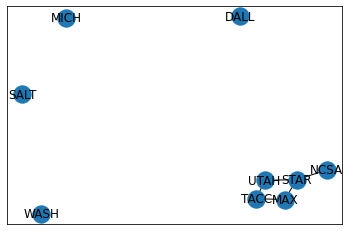

In [60]:
if return_status == Status.OK:
    advertised_topology.draw()

## Configure Slice Parameters



In [61]:
slice_name = 'MySliceUbuntu'
site = 'MAX'
node_name = 'Node1'
username = 'ubuntu'
image = 'default_ubuntu_20'
image_type = 'qcow2'
cores = 2
ram = 2
disk = 2

## Create Slice

Creates a single node with basic compute capabilities.

<img src="./figs/SingleNode.png" width="40%"><br>


In [62]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType, Labels
# Create topology
experiment = ExperimentTopology()

# Add node
node = experiment.add_node(name=node_name, site=site)

# Set capacities
cap = Capacities()
cap.set_fields(core=cores, ram=ram, disk=disk)

# Set Properties
node.set_properties(capacities=cap, image_type=image_type, image_ref=image)

# Generate Slice Graph
slice_graph = experiment.serialize()

# Request slice from Orchestrator
return_status, slice_reservations = slice_manager.create(slice_name=slice_name, slice_graph=slice_graph, ssh_key=vm_public_key)

if return_status == Status.OK:
    slice_id = slice_reservations[0].get_slice_id()
    print("Submitted slice creation request. Slice ID: {}".format(slice_id))
else:
    print(f"Failure: {slice_reservations}")

Submitted slice creation request. Slice ID: 7127eef4-cea2-4a31-b9eb-44042b4dac22


## Query Slices

You can get a list of all your slices from the slice manager. If this is your first slice, it should return only one slice.

<div class="alert alert-block alert-info">
<b>Note:</b> The status returned by the call to slices indicates the success or failure of the call to the FABRIC control framework. The status is not the status of the slices.  The status of each slice is included in the list of slices.
</div>



 

In [63]:
return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

if return_status == Status.OK:
    for slice in slices:
        print("{}:".format(slice.slice_name))
        print("   ID         : {}".format(slice.slice_id))
        print("   State      : {}".format(slice.slice_state))
        print("   Lease End  : {}".format(slice.lease_end))
        print()
else:
    print(f"Failure: {slices}")

MySliceUbuntu:
   ID         : 7127eef4-cea2-4a31-b9eb-44042b4dac22
   State      : Configuring
   Lease End  : 2021-12-04 04:49:52



## Get the New Slice

You new slice is in the list of all your slices. You can loop through the list of slices to get the new slice. Python has a standard tool to filter lists. Try using a lambda function to filter out your slice using its name.

In [64]:
slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]

print("Slice Name : {}".format(slice.slice_name))
print("ID         : {}".format(slice.slice_id))
print("State      : {}".format(slice.slice_state))
print("Lease End  : {}".format(slice.lease_end))

Slice Name : MySliceUbuntu
ID         : 7127eef4-cea2-4a31-b9eb-44042b4dac22
State      : Configuring
Lease End  : 2021-12-04 04:49:52


## Wait for the Slice to Build

In [65]:
import time
def wait_for_slice(slice,timeout=180,interval=10,progress=False):
    timeout_start = time.time()

    if progress: print("Waiting for slice .", end = '')
    while time.time() < timeout_start + timeout:
        return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

        if return_status == Status.OK:
            slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
            if slice.slice_state == "StableOK":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice
            if slice.slice_state == "Closing" or slice.slice_state == "Dead":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice    
        else:
            print(f"Failure: {slices}")
        
        if progress: print(".", end = '')
        time.sleep(interval)
    
    if time.time() >= timeout_start + timeout:
        if progress: print(" Timeout exceeded ({} sec). Slice: {} ({})".format(timeout,slice.slice_name,slice.slice_state))
        return slice    

            
            
slice = wait_for_slice(slice, progress=True)
print()

print("Slice Name : {}".format(slice.slice_name))
print("ID         : {}".format(slice.slice_id))
print("State      : {}".format(slice.slice_state))
print("Lease End  : {}".format(slice.lease_end))

Waiting for slice .... Slice state: StableOK

Slice Name : MySliceUbuntu
ID         : 7127eef4-cea2-4a31-b9eb-44042b4dac22
State      : StableOK
Lease End  : 2021-12-04 04:49:52


## Get the Slice Topology

In [66]:
return_status, experiment_topology = slice_manager.get_slice_topology(slice_object=slice)

for node_name, node in experiment_topology.nodes.items():
    print("Node:")
    print("   Name              : {}".format(node.name))
    print("   Cores             : {}".format(node.get_property(pname='capacity_allocations').core))
    print("   RAM               : {}".format(node.get_property(pname='capacity_allocations').ram))
    print("   Disk              : {}".format(node.get_property(pname='capacity_allocations').disk))
    print("   Image             : {}".format(node.image_ref))
    print("   Image Type        : {}".format(node.image_type))
    print("   Host              : {}".format(node.get_property(pname='label_allocations').instance_parent))
    print("   Site              : {}".format(node.site))
    print("   Management IP     : {}".format(node.management_ip))
    print("   Reservation ID    : {}".format(node.get_property(pname='reservation_info').reservation_id))
    print("   Reservation State : {}".format(node.get_property(pname='reservation_info').reservation_state))
    print("   Components        : {}".format(node.components))
    print("   Interfaces        : {}".format(node.interfaces))
    print()    


Node:
   Name              : Node1
   Cores             : 2
   RAM               : 8
   Disk              : 10
   Image             : default_ubuntu_20
   Image Type        : qcow2
   Host              : max-w4.fabric-testbed.net
   Site              : MAX
   Management IP     : 63.239.135.71
   Reservation ID    : d575c48b-6f3d-4799-809b-23555a195aa2
   Reservation State : Active
   Components        : {}
   Interfaces        : {}



## Accessing the VM

### Terminal SSH Commmand

Connecting to your VMs requests you to jump through the bastion host to the VM using the keys configured above. From a terminal you can ssh to the to the VM using the command generated by the following command.


In [67]:
print('ssh -i {} -i {} -J {}@{} {}@{}'.format(bastion_private_key_file,
                                           vm_private_key_file,
                                           bastion_username,
                                           bastion_public_addr,
                                           username,
                                           node.management_ip))

ssh -i /home/charles/.ssh/extra_keys/unbridled_linux -i /home/charles/.ssh/fabric_slice/id_rsa -J charles@bastion-1.fabric-testbed.net ubuntu@63.239.135.71


### SSH with Python (paramiko)

Most experiments will require automated configuration and execution. You can use the paramiko Python library to execute arbitrary commands on your VMs. 

The following cells use paramiko to execute a "Hello, FABRIC" bash script. The cell uses the bastion and VM keys defined at the top of this notebook to jump through the bastion host and executed the script.


In [110]:
script= '#!/bin/bash  \n' \
        'sudo apt update   \n' \
        'sudo apt install -y python3-pip   \n' \
        'pip3 --version \n' \
        'pip install ansible \n' \
        'ansible --version \n' \
        'ansible-galaxy --version \n' \
        'mkdir -p mf_git \n' \
        'git clone https://github.com/fabric-testbed/MeasurementFramework.git mf_git \n' \
        'cd mf_git \n' \
        'git checkout add_fabric_experiment_role \n' \
        'cd ansible/fabric_experiment_instramentize \n' \
        'pwd \n' \
        'ansible-playbook playbook_fabric_experiment_bootstrap1.yml \n'  \
        'echo "Finished!" \n'
                   
        

In [111]:
from ipaddress import ip_address, IPv4Address
def validIPAddress(IP: str) -> str:
    try:
        return "IPv4" if type(ip_address(IP)) is IPv4Address else "IPv6"
    except ValueError:
        return "Invalid"

import paramiko
for node_name, node in experiment_topology.nodes.items():
    try:
        management_ip = str(node.get_property(pname='management_ip'))
        print("Node {0} IP {1}".format(node_name, management_ip))

        key = paramiko.RSAKey.from_private_key_file(vm_private_key_file)

        bastion=paramiko.SSHClient()
        bastion.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        bastion.connect(bastion_public_addr, username=bastion_username, key_filename=bastion_private_key_file)

    
        bastion_transport = bastion.get_transport()
        if validIPAddress(management_ip) == 'IPv4':
            src_addr = (bastion_private_ipv4_addr, 22)
        elif validIPAddress(management_ip) == 'IPv6':
            src_addr = (bastion_private_ipv6_addr, 22)
        else:
            print('Management IP Invalid: {}'.format(management_ip))

        dest_addr = (management_ip, 22)
        bastion_channel = bastion_transport.open_channel("direct-tcpip", dest_addr, src_addr)


        client = paramiko.SSHClient()
        client.load_system_host_keys()
        client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
        client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

        client.connect(management_ip,username=username,pkey = key, sock=bastion_channel)

        stdin, stdout, stderr = client.exec_command('echo \"' + script + '\" > script.sh; chmod +x script.sh; sudo ./script.sh')
        print ('')
        print (str(stdout.read(),'utf-8').replace('\\n','\n'))
        print (str(stderr.read(),'utf-8').replace('\\n','\n'))

        client.close()
    except Exception as e:
        print(str(e))



Node Node1 IP 63.239.135.71

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
Reading package lists...
Building dependency tree...
Reading state information...
40 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Building dependency tree...
Reading state information...
python3-pip is already the newest version (20.0.2-5ubuntu1.6).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
pip 20.0.2 from /usr/lib/python3/dist-packages/pip (python 3.8)
ansible [core 2.12.0]
  config file = None
  configured module search path = ['/root/.ansible/plugins/modules', '/usr/share/ansible/plugins/modules']
  ansible python module location = /usr/local/lib/python3.8/dist-packages/ansible
  ansible collection location 

## Delete Slice

In [53]:
return_status, result = slice_manager.delete(slice_object=slice)

print("Response Status {}".format(return_status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
